# Link Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir -p ~/.kaggle

In [ ]:
! cp '/content/drive/MyDrive/Colab Notebooks/kaggle_API_key/kaggle.json' ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

### Import Playground Series Data

In [ ]:
! kaggle competitions download -c playground-series-s6e1

playground-series-s6e1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip playground-series-s6e1.zip

Archive:  playground-series-s6e1.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import Machine Learning Libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder,LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

### Dataframe Creation and Exploration

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [ ]:
# Explore the data
train_df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [ ]:
# Basic data prep
print('Data Shape: \n', train_df.shape)
print('\n Data Types: \n', train_df.dtypes)
print('\n Missing Values: \n', train_df.isnull().sum())

Data Shape: 
 (630000, 13)

 Data Types: 
 id                    int64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object

 Missing Values: 
 id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64


### Basic feature encoding

In [ ]:
# Create a copy to avoid modifying original
df_encoded = train_df.copy()

# Binary encoding
df_encoded['internet_access'] = df_encoded['internet_access'].map({'no': 0, 'yes': 1})

# Ordinal encoding
ordinal_mappings = {
    'sleep_quality': {'poor': 0, 'average': 1, 'good': 2},
    'facility_rating': {'low': 0, 'medium': 1, 'high': 2},
    'exam_difficulty': {'easy': 0, 'moderate': 1, 'hard': 2}
}

for col, mapping in ordinal_mappings.items():
    df_encoded[col] = df_encoded[col].map(mapping)

# One-hot encoding
df_encoded = pd.get_dummies(df_encoded,
                            columns=['course', 'study_method', 'gender'],
                            dtype = int,      # Binary
                            drop_first=True)  # Avoid multicollinearity

# Encoded DataFrame
df_encoded.head()



,id,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score,...,course_ba,course_bba,course_bca,course_diploma,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study,gender_male,gender_other
0,0,21,7.91,98.8,0,4.9,1,0,0,78.3,...,0,0,0,0,0,0,1,0,0,0
1,1,18,4.95,94.8,1,4.7,0,1,1,46.7,...,0,0,0,1,0,0,0,1,0,1
2,2,20,4.68,92.6,1,5.8,0,2,1,99.0,...,0,0,0,0,0,0,0,0,0,0
3,3,19,2.00,49.5,1,8.3,1,2,1,63.9,...,0,0,0,0,1,0,0,0,1,0
4,4,23,7.65,86.9,1,9.6,2,2,0,100.0,...,0,0,1,0,0,0,0,1,1,0


### View Correlation

<Axes: >

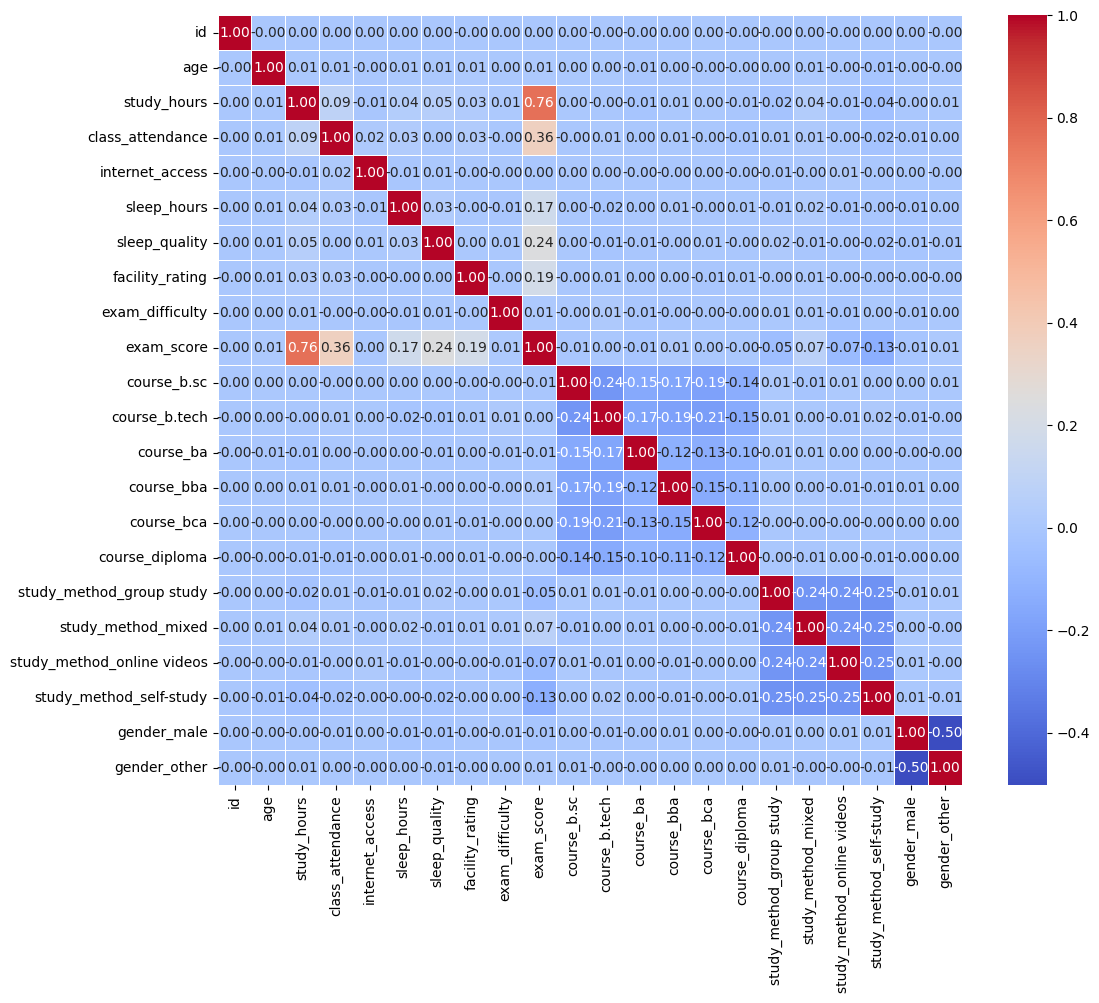

In [ ]:
corr = df_encoded.corr(numeric_only=True)

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

### Prepare Data and Scale Features

In [ ]:
# Separate features and target
X = df_encoded.drop(['id', 'exam_score'], axis=1)
y = df_encoded['exam_score']

# Then split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Amount: \n {len(X_train)}")
print(f"\n Test Amount: \n {len(X_test)}")

Train Amount: 
 504000

 Test Amount: 
 126000


In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### XGBoost Model Params

In [ ]:
# XGBoost model
model = xgb.XGBRegressor(
    n_estimators=250,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1,
    random_state=42,
    objective='reg:squarederror',
    eval_metric='rmse'
)

In [ ]:
# Fit the model first
model.fit(X_train_scaled, y_train)

# Generate predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calculate RMSE
train_rmse = root_mean_squared_error(y_train, y_pred_train)
test_rmse = root_mean_squared_error(y_test, y_pred_test)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")


Training RMSE: 8.56
Test RMSE: 8.76


### Make Predictions on Test Data

In [ ]:
# Create a copy to avoid modifying original
test_encoded = test_df.copy()

# Binary encoding
test_encoded['internet_access'] = test_encoded['internet_access'].map({'no': 0, 'yes': 1})

# Ordinal encoding
ordinal_mappings = {
    'sleep_quality': {'poor': 0, 'average': 1, 'good': 2},
    'facility_rating': {'low': 0, 'medium': 1, 'high': 2},
    'exam_difficulty': {'easy': 0, 'moderate': 1, 'hard': 2}
}

for col, mapping in ordinal_mappings.items():
    test_encoded[col] = test_encoded[col].map(mapping)

# One-hot encoding
test_encoded = pd.get_dummies(test_encoded,
                            columns=['course', 'study_method', 'gender'],
                            dtype = int,      # Binary
                            drop_first=True)  # Avoid multicollinearity

# Prepare for prediction
test_ids = test_encoded['id']
X_test_kaggle = test_encoded.drop(['id'], axis=1)

# Scale and predict
X_test_kaggle_scaled = scaler.transform(X_test_kaggle)
predictions = model.predict(X_test_kaggle_scaled)

# Create submission
submission = pd.DataFrame({
    'id': test_ids,
    'exam_score': predictions
})

submission.to_csv('submission_3.csv', index=False)
print(f"Submission created with {len(predictions)} predictions")
submission.head()

Submission created with 270000 predictions


,id,exam_score
0,630000,71.373016
1,630001,70.546562
2,630002,88.101852
3,630003,57.387100
4,630004,48.299957
